In [31]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from datetime import datetime as dt

import lightgbm
import optuna

## Dataset

In [55]:
# 학습 데이터
train = pd.read_csv('./train.csv')
train

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 제품 품질 상태(Target) (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)
* Y_Quality : 제품 품질 수치
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [56]:
test = pd.read_csv('./test.csv')
test.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [57]:
subm = pd.read_csv('./sample_submission.csv')
subm.head()

,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 예측한 제품 품질 상태 (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)

In [62]:
for code in train['PRODUCT_CODE'].unique():
    print(code, len(train[train['PRODUCT_CODE']==code]))

A_31 249
T_31 343
O_31 6


In [72]:
train[train[train.columns[6]].isnull()]

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71,59.64,54.61,57.05,63.18,1.0,NaN,NaN,NaN,NaN
584,TRAIN_584,0,0.519519,2022-09-05 11:09,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,TRAIN_585,0,0.515214,2022-09-05 11:17,T010306,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN


In [81]:
train[train['X_92'].isnull()]['PRODUCT_CODE'].value_counts()

A_31    249
T_31    171
O_31      3
Name: PRODUCT_CODE, dtype: int64

In [74]:
for i in range(6, len(train.columns)):
    if len(train[train[train.columns[i]].isnull()]) not in [249, 343, 6]:
        print(train.columns[i], len(train[train[train.columns[i]].isnull()]))

X_92 423
X_93 424
X_94 424
X_95 424
X_104 424
X_113 423
X_114 423
X_115 423
X_124 423
X_125 423
X_126 424
X_127 424
X_128 520
X_129 520
X_130 556
X_131 556
X_132 478
X_133 478
X_134 478
X_135 478
X_136 478
X_137 478
X_138 478
X_139 478
X_140 478
X_141 478
X_142 478
X_143 478
X_144 478
X_145 478
X_146 478
X_147 478
X_148 478
X_149 478
X_150 478
X_151 478
X_152 478
X_153 478
X_154 478
X_155 478
X_156 478
X_157 478
X_158 478
X_159 478
X_160 478
X_161 478
X_162 478
X_163 478
X_164 478
X_165 478
X_166 478
X_167 478
X_168 478
X_169 478
X_170 478
X_171 478
X_172 478
X_173 478
X_174 478
X_175 478
X_176 478
X_177 478
X_178 478
X_179 478
X_180 478
X_181 478
X_182 478
X_183 478
X_184 478
X_185 478
X_186 478
X_187 478
X_188 478
X_189 478
X_190 478
X_191 478
X_192 478
X_193 478
X_194 478
X_195 478
X_196 478
X_197 478
X_198 478
X_199 478
X_200 478
X_201 478
X_202 478
X_203 478
X_204 478
X_205 478
X_206 478
X_207 478
X_208 478
X_209 478
X_210 478
X_211 478
X_212 478
X_213 478
X_214 478
X_215 478
X_21

X_1078 349
X_1079 349
X_1080 349
X_1081 349
X_1082 349
X_1083 349
X_1084 349
X_1085 349
X_1086 349
X_1087 349
X_1088 349
X_1089 349
X_1090 349
X_1091 349
X_1092 349
X_1093 349
X_1094 349
X_1095 349
X_1096 349
X_1097 349
X_1098 349
X_1099 349
X_1100 349
X_1101 349
X_1102 349
X_1103 349
X_1104 349
X_1105 349
X_1106 349
X_1107 349
X_1108 349
X_1109 349
X_1110 349
X_1111 349
X_1112 349
X_1113 349
X_1114 349
X_1115 349
X_1116 349
X_1117 349
X_1118 349
X_1119 349
X_1120 349
X_1121 349
X_1122 349
X_1123 349
X_1124 349
X_1125 349
X_1126 349
X_1127 349
X_1128 349
X_1129 349
X_1130 349
X_1131 349
X_1132 349
X_1133 349
X_1134 349
X_1135 349
X_1136 349
X_1137 349
X_1138 349
X_1139 349
X_1140 349
X_1141 349
X_1142 349
X_1143 349
X_1144 349
X_1145 349
X_1146 349
X_1147 349
X_1148 349
X_1149 349
X_1150 349
X_1151 349
X_1152 349
X_1153 349
X_1154 349
X_1155 349
X_1156 349
X_1157 349
X_1158 351
X_1159 351
X_1160 351
X_1161 351
X_1162 351
X_1163 351
X_1164 351
X_1165 351
X_1166 351
X_1167 504
X_1168 504

X_1836 478
X_1837 478
X_1838 478
X_1839 478
X_1840 478
X_1841 478
X_1842 478
X_1843 478
X_1844 478
X_1845 478
X_1846 478
X_1847 478
X_1848 478
X_1849 478
X_1850 478
X_1851 478
X_1852 478
X_1853 478
X_1854 478
X_1855 478
X_1856 478
X_1857 478
X_1858 478
X_1859 478
X_1860 478
X_1861 478
X_1862 478
X_1863 478
X_1864 478
X_1865 478
X_1866 478
X_1867 478
X_1868 478
X_1869 478
X_1870 478
X_1871 478
X_1872 478
X_1873 478
X_1874 478
X_1875 478
X_1876 478
X_1877 478
X_1878 478
X_1879 478
X_1880 478
X_1881 478
X_1882 478
X_1883 478
X_1884 478
X_1885 478
X_1886 478
X_1887 478
X_1888 478
X_1889 478
X_1890 478
X_1891 478
X_1892 478
X_1893 478
X_1894 478
X_1895 478
X_1896 478
X_1897 478
X_1898 478
X_1899 478
X_1900 478
X_1901 478
X_1902 478
X_1903 478
X_1904 478
X_1905 478
X_1906 478
X_1907 478
X_1908 478
X_1909 478
X_1910 478
X_1911 478
X_1912 478
X_1913 478
X_1914 478
X_1915 478
X_1916 478
X_1917 478
X_1918 478
X_1919 478
X_1920 478
X_1921 478
X_1922 478
X_1923 478
X_1924 478
X_1925 478
X_1926 478

X_2595 536
X_2596 536
X_2597 536
X_2598 536
X_2599 536
X_2600 536
X_2601 536
X_2602 536
X_2603 536
X_2604 536
X_2605 536
X_2606 536
X_2607 536
X_2608 536
X_2609 536
X_2610 536
X_2611 536
X_2612 536
X_2613 536
X_2614 536
X_2615 536
X_2616 536
X_2617 536
X_2618 536
X_2619 536
X_2620 536
X_2621 536
X_2622 536
X_2623 536
X_2624 536
X_2625 536
X_2626 536
X_2627 536
X_2628 598
X_2629 598
X_2630 598
X_2631 598
X_2632 598
X_2633 598
X_2634 598
X_2635 598
X_2636 598
X_2637 598
X_2638 598
X_2639 598
X_2640 598
X_2641 598
X_2642 598
X_2643 598
X_2644 598
X_2645 598
X_2646 598
X_2647 598
X_2648 598
X_2649 598
X_2650 598
X_2651 598
X_2652 598
X_2653 598
X_2654 598
X_2655 598
X_2656 598
X_2657 598
X_2658 598
X_2659 598
X_2660 598
X_2661 598
X_2662 598
X_2663 598
X_2664 598
X_2665 598
X_2666 598
X_2667 598
X_2668 598
X_2669 598
X_2670 598
X_2671 598
X_2672 598
X_2673 598
X_2674 598
X_2675 598
X_2676 598
X_2677 598
X_2678 598
X_2679 598
X_2680 598
X_2681 598
X_2682 598
X_2683 598
X_2684 598
X_2685 598

In [48]:
# X에 관한 Column들은 무의미 해보인다.
train = train[train.columns[:6]]
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31


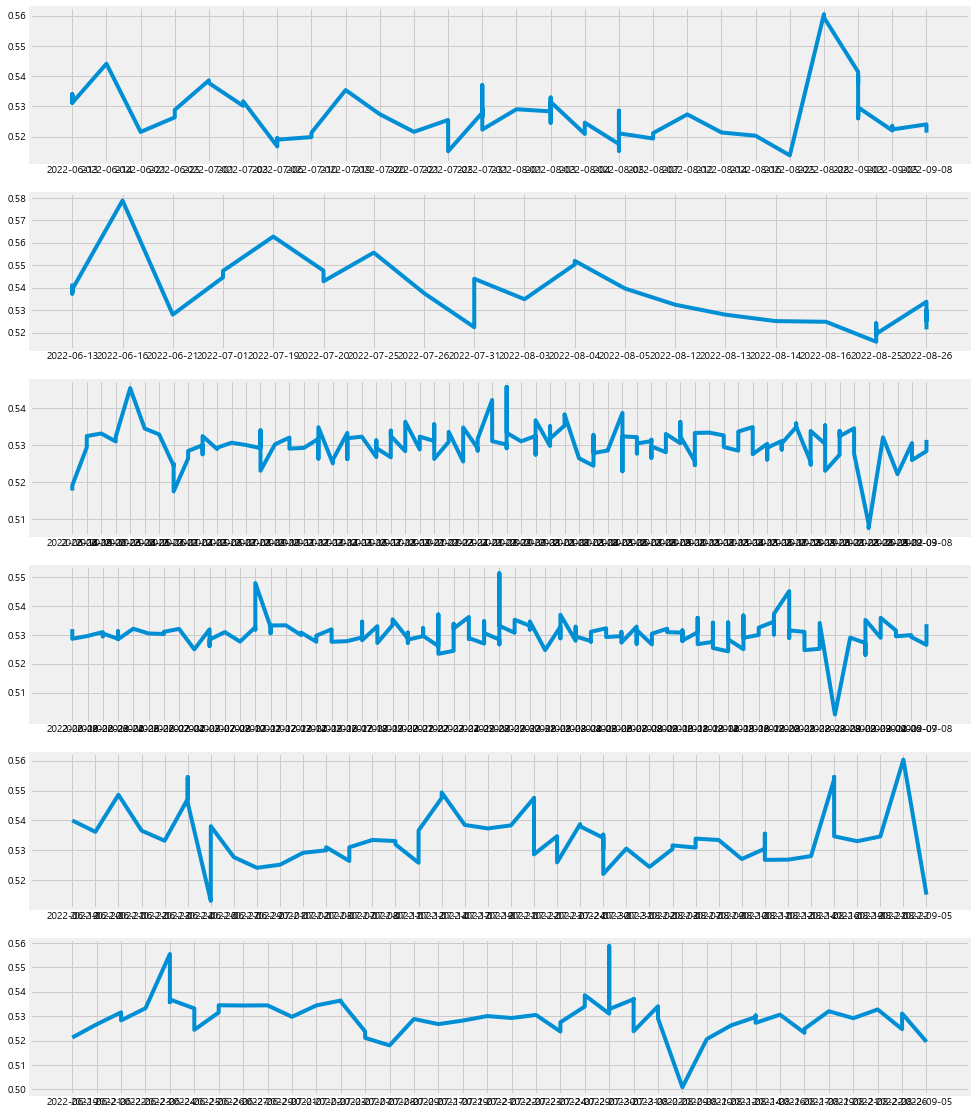

In [53]:
# Timeseries의 성질을 가지고 있지 않다.
rcParams['figure.figsize'] = 15, 20

for i, line in enumerate(train.LINE.unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['LINE']==line]
    tmp['TIMESTAMP'] = pd.to_datetime(train['TIMESTAMP']).dt.strftime('%Y-%m-%d')
    plt.plot(tmp['TIMESTAMP'], tmp['Y_Quality'])
plt.show()

In [54]:
train.drop(columns='TIMESTAMP', inplace=True)
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,LINE,PRODUCT_CODE
0,TRAIN_000,1,0.533433,T050304,A_31
1,TRAIN_001,2,0.541819,T050307,A_31
2,TRAIN_002,1,0.531267,T050304,A_31
3,TRAIN_003,2,0.537325,T050307,A_31
4,TRAIN_004,1,0.531590,T050304,A_31


In [43]:
train.PRODUCT_CODE.unique()

array(['A_31', 'T_31', 'O_31'], dtype=object)

In [ ]:
train